# NOTICE

It would be ill advised to run this notebook in its entirety on a computer with less than 16 GB of RAM.

The notebook easily sucks up 8GB RAM on its own, and any further manipulations with it will increase that number.

In [1]:
# Hacky workaround to stop the kernel from dying.
# Apparently numpy, pytorch, scipy, are loading multiple versions of linear algebra libraries
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal # Savitzky-Galoy filter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

if device.type == "cuda":
    print("Torch is using CUDA")
    torch.cuda.reset_peak_memory_stats()
else:
    print("Torch is using CPU")

infile = open("data/capture_base.bin")
y_base = np.fromfile(infile, dtype = np.int16)[2::4]

infile = open("data/capture_wave.bin")
y_wave = np.fromfile(infile, dtype = np.int16)[2::4]

#y = y_wave - y_base
y = y_wave

# Trim the bad bits of the data off
y = y[10000:]

y = torch.from_numpy(y).to(torch.float32).to(device)

# Keep every 16th sample (has to be a clean power of 2 for later slicing to find where peaks are)
y = y[::16]
    
def PrintGPUMemoryStatistics():
    print("Current GPU MB allocated: " + str(torch.cuda.memory_allocated() / 1024 / 1024))
    print("Max GPU MB allocated: " + str(torch.cuda.max_memory_allocated() / 1024 / 1024))

def ClearGPUMemoryCache():
    print("Clearing GPU Memory Cache")
    with torch.no_grad():
        torch.cuda.empty_cache()

ClearGPUMemoryCache()
PrintGPUMemoryStatistics()

Torch is using CUDA
Clearing GPU Memory Cache
Current GPU MB allocated: 38.10888671875
Max GPU MB allocated: 38.10888671875


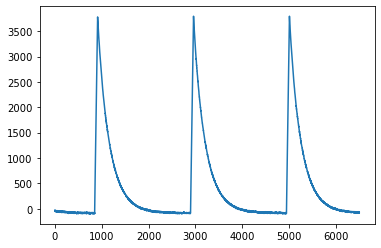

In [2]:
plt.plot(y[500:7000].cpu())
plt.show()

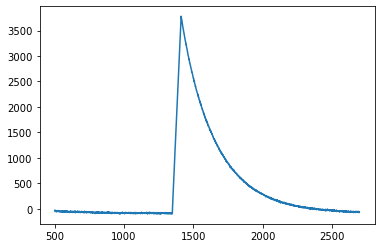

In [3]:
plt.plot(np.arange(500, 2700, 1), y[500:2700].cpu())
plt.show()

From the plot above, we can see that a slice of a signal including the background noise before and after the pulse is around 2200 samples long.

At our clock rate of 125 MHz, we were generating these pulses once every $2^{15}$ cycles. We decimated our clock rate by only taking every 16th sample. Now we will be generating pulses every $2^{15 - 4} = 2^{11}$ cycles.

Just the other pulse


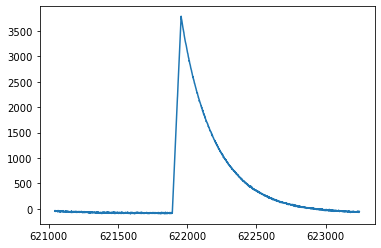

Both of them


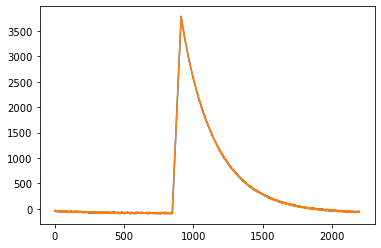

Difference between them


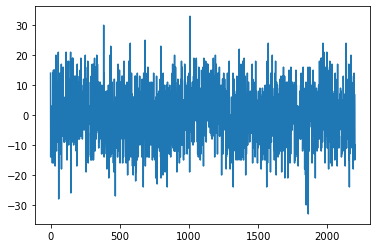

In [4]:
print("Just the other pulse")
n = 2 ** (15 - 4) * 303
plt.plot(np.arange(500 + n, 2700 + n, 1), y[500 + n:2700 + n].cpu())
plt.show()

print("Both of them")
plt.plot(y[500 + n:2700 + n].cpu())
plt.plot(y[500:2700].cpu())
plt.show()

print("Difference between them")
plt.plot((y[500:2700] - y[500 + n:2700 + n]).cpu())
plt.show()

In [5]:
# This is how many total exponential waveforms we have from our acquisition
print(len(y) / (2 ** 11))

print(len(y) >> (15 - 4))

# So from index 0 to index 303

304.87060546875
304


Now that we can accurately determine where waveforms stop and start, we should build an array of all of them.

Here the rows are all of our sample waveforms.

In [6]:
waveforms = []

for i in range(0, len(y) >> 11):
    waveform = y[500 + i * (1 << 11):2700 + i * (1 << 11)]
    waveforms.append(waveform)
    
waveforms = torch.stack(waveforms).to(device)

ClearGPUMemoryCache()
PrintGPUMemoryStatistics()

Clearing GPU Memory Cache
Current GPU MB allocated: 40.66015625
Max GPU MB allocated: 40.66015625


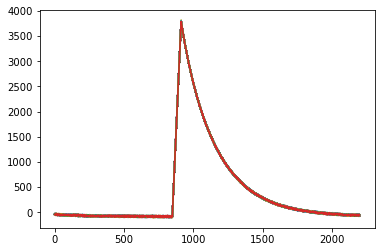

In [7]:
for waveform in waveforms:
    plt.plot(waveform.cpu())

plt.show()

Now let's calculate the covariance matrix of the points in this waveform

In [8]:
def build_cov_mat(waveforms, batch_size):
    total_points = waveforms.shape[1]
    cov_mat = torch.zeros(total_points, total_points).to(device)
    
    for i in range(int(total_points / batch_size)):
        y_i_samples = waveforms.T[i * batch_size:(i + 1) * batch_size]
        y_i_diff = y_i_samples - torch.mean(y_i_samples, dim = 1)[:, None]
        for j in range(i, int(total_points / batch_size)):
            y_j_samples = waveforms.T[j * batch_size:(j + 1) * batch_size]
            y_j_diff = y_j_samples - torch.mean(y_j_samples, dim = 1)[:, None]

            cov_mat[i * batch_size:(i + 1) * batch_size, j * batch_size:(j + 1) * batch_size] = y_i_diff @ y_j_diff.T / waveforms.shape[0]

    # build using the upper triangle
    cov_mat = torch.triu(cov_mat) + torch.triu(cov_mat, diagonal = 1).T
    
    return cov_mat

In [9]:
cov_mat = build_cov_mat(waveforms, 100)

ClearGPUMemoryCache()
PrintGPUMemoryStatistics()

Clearing GPU Memory Cache
Current GPU MB allocated: 59.12353515625
Max GPU MB allocated: 114.74609375


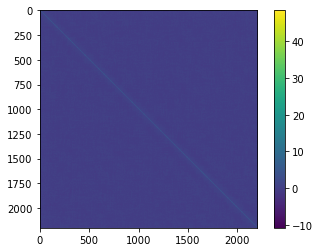

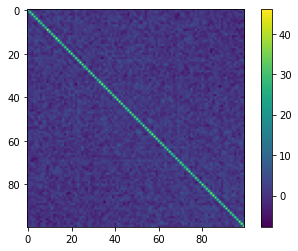

In [10]:
plt.imshow(cov_mat.cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(cov_mat[0:100,0:100].cpu().numpy())
plt.colorbar()
plt.show()

Now let's do the same thing, but take a window of 600 points of the waveform instead of all of it. This means we will get a 600x600 covariance matrix. This is *NOT* a sliding window though.

In [11]:
cov_mat = build_cov_mat(waveforms[:,0:600], 100)

ClearGPUMemoryCache()
PrintGPUMemoryStatistics()

Clearing GPU Memory Cache
Current GPU MB allocated: 42.03369140625
Max GPU MB allocated: 114.74609375


In [12]:
cov_mat

tensor([[34.1827,  2.8612, -0.9852,  ...,  0.4489, -1.2636, -3.9244],
        [ 2.8612, 35.7140,  3.6635,  ...,  3.6271, -3.9830,  0.5228],
        [-0.9852,  3.6635, 41.3962,  ..., -3.3089, -0.9361, -1.1328],
        ...,
        [ 0.4489,  3.6271, -3.3089,  ..., 37.3207, -0.8164, -1.7223],
        [-1.2636, -3.9830, -0.9361,  ..., -0.8164, 41.8829,  6.2019],
        [-3.9244,  0.5228, -1.1328,  ..., -1.7223,  6.2019, 35.5585]],
       device='cuda:0')

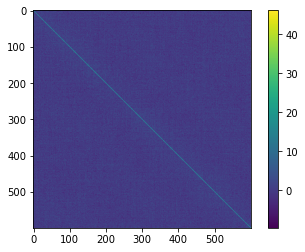

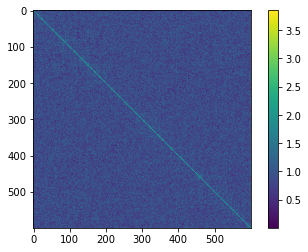

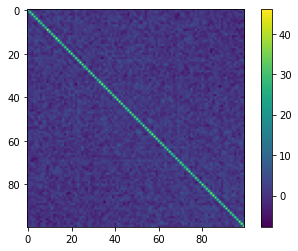

In [27]:
plt.imshow(cov_mat.cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(torch.log(1 + torch.abs(cov_mat)).cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(cov_mat[0:100,0:100].cpu().numpy())
plt.colorbar()
plt.show()

And finally, let's do this same 600 point covariance matrix, but slide that window across the sample waveforms. We will get a different covariance matrix for every single different window we can take.

In [14]:
waveform_windows = waveforms.T.unfold(0, 600, 1)

ClearGPUMemoryCache()
PrintGPUMemoryStatistics()

Clearing GPU Memory Cache
Current GPU MB allocated: 42.03369140625
Max GPU MB allocated: 114.74609375


In [15]:
cov_mats = []

for window in waveform_windows:
    cov_mats.append(build_cov_mat(window, 100).to("cpu"))

cov_mats = torch.stack(cov_mats)

ClearGPUMemoryCache()
PrintGPUMemoryStatistics()

Clearing GPU Memory Cache
Current GPU MB allocated: 42.03369140625
Max GPU MB allocated: 114.74609375


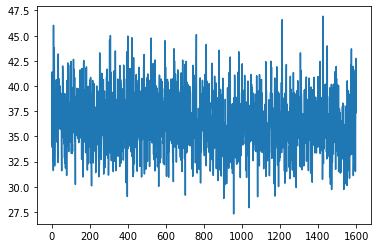

In [16]:
plt.plot(cov_mats[:, 0, 0])
plt.show()

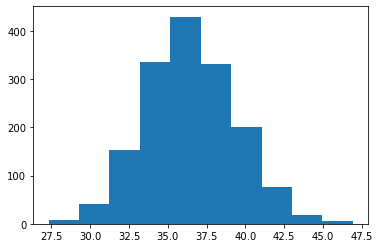

In [24]:
plt.hist(cov_mats[:,0,0].numpy())
plt.show()